# Malware detection from PCAP Network Captures

> This is a project to detect malware from PCAP network captures. 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export 

import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Any, Optional, Union

import ipaddress
from collections import OrderedDict
from datetime import datetime

import netaddr
import numpy as np
import pandas as pd
from scapy.all import *

import joblib
from fastcore.basics import patch 
import hashlib

import mdetect

## Processing PCAP files

The first step is to process the PCAP files and extract the features. The main library I am using for this is scapy, but I am going to create some helper functions to make it easier to extract the features I want. The starting point for this code is taken from the githib repo [netml](https://github.com/noise-lab/netml), although I have mofified it to suit this project. 

The overall technique I am employing in the notebook is translate the PCAP files into a set of sessions (flows), where a flow is defined by a 5-tuple (src IP, src port, dst IP, dst port, protocol). I am then extracting features from each flow, and then using these features to train a classifier. The classifier will then be used to predict whether a flow is malicious or not. Since an individual pcap file will usually be comprised of several flows, and extra step is required to combine the predictions for each flow into a single prediction for the pcap file. 


The following sets up the data locations and creates some lists of files to process.

In [ ]:
# Setup the training and validation dataset paths and create some lists of files.

BASE_PATH = Path(mdetect.__path__[0]).parent

DATA_PATH = BASE_PATH/ 'data'
MPATH = DATA_PATH / 'malware'
BPATH = DATA_PATH / 'benign'


malware_files = list(MPATH.glob('**/*.pcap'))
benign_files = list(BPATH.glob('**/*.pcap*'))

print(f'Number of malware files: {len(malware_files)}')
print(f'Number of benign files: {len(benign_files)}')

Number of malware files: 8
Number of benign files: 3


In [ ]:
#| export 

def _get_fid(pkt):
    """Extract fid (five-tuple) from a packet: only focus on IPv4
    Parameters
    ----------

    Returns
    -------
        fid: five-tuple (IP src, IP dst, src port, dst port, protocol)
    """

    if IP in pkt and TCP in pkt:
        fid = (pkt[IP].src, pkt[IP].dst, pkt[TCP].sport, pkt[TCP].dport, 'TCP')
    elif IP in pkt and UDP in pkt:
        fid = (pkt[IP].src, pkt[IP].dst, pkt[UDP].sport, pkt[UDP].dport, 'UDP')
    elif ICMP in pkt:
        fid = ('', '', pkt[ICMP].sport, pkt[ICMP].dport, "ICMP")
    else: 
        fid = ('', '', -1, -1, "UNK")

    return fid

def _get_frame_time(pkt):
    return float(pkt.time)

def flow_duration(pkts: List) -> float:
    pkt_times = [float(pkt.time) for pkt in pkts]
    flow_duration = max(pkt_times) - min(pkt_times)
    return flow_duration
    


The following defines the basic data structures for extracting flows from the PCAP files.

In [ ]:
#| export 


class PacketFlows:
    
    def __init__(self, 
                 pcap_file: Path, 
                 interval: float = 0, 
                 q_interval: float = 0.90,
                 min_pkts: int = 2, 
                 tcp_timeout: int = 600, 
                 udp_timeout: int = 600, 
                 verbose: int = 0):
        """
        Parameters
        ----------
        pcap: Path or str
            a pcap needed to processed.

        min_pkts: int (default is 2)
            the minimum number of packets of each flow is to control which flow should be kept
            and which one should be discarded. The default value is 2, i.e., all the flows which have less than 2 packets
            are discarded. It must be >= 2.

        tcp_timeout: int (default is 600s)
            a timeout is to split flow

        ucp_timeout: int (default is 600s)
            a timeout is to split flow

        verbose: int (default is 1)
            a print level is to control what information should be printed according to the given value.
            The higher the value is, the more info is printed.

        """
        self.min_pkts = min_pkts
        self.tcp_timeout = tcp_timeout
        self.udp_timeout = udp_timeout
        self.verbose = verbose
        self.pcap_file = str(pcap_file)
        self.name = pcap_file.name
        
        # Seperate into seperate flows, not segmented by time
        full_flow = self._pcap2flows()
        # Get the time interval used to seperate flows by time segment
        self.interval = self._fetch_interval(full_flow, interval, q_interval)
        # Seperate into flows segmented by time, using the interval as the time segment
        self.flows = self.flows2subflows(full_flow, self.interval)
        
    def _fetch_interval(self, 
                        fflow: OrderedDict,
                        interval: float, 
                        q_interval: float) -> float:
        if interval > 0:
            return interval
        else:
            if q_interval > 0:
                self.flow_durations = [flow_duration(pkts) for fid, pkts in fflow]
                self.interval = self.split_interval(self.flow_durations, q_interval=q_interval)
                return self.interval
            else:
                msg = f'q_interval must be in [0, 1]! Current q_interval is {q_interval}.'
                raise ValueError(msg)
            
    def split_interval(self, 
                       flow_durations: List[float], 
                       q_interval: float =0.9):
        interval = np.quantile(flow_durations, q=q_interval)
        return interval
        
    def __getitem__(self, index: int):
        return self.flows[index] 
    
    def __len__(self):
        return len(self.flows)   
    
    def __iter__(self):
        return iter(self.flows)

    def summary(self):
        print(f'pcap_file: {self.pcap_file}')
        print("Number of flows: ", len(self.flows))
        print("Number of packets in each flow: ", [len(v[1]) for v in self.flows])
        
    @property
    def src_ports(self) -> np.array:
        return np.array([flow[0][2] for flow in self.flows])
        
    @property
    def dst_ports(self) -> np.array:
        return np.array([flow[0][3] for flow in self.flows])
        
    @property
    def protocols(self) -> np.array:
        return np.array([str(flow[0][4]) for flow in self.flows])

    def _pcap2flows(self) -> OrderedDict:
    
        # store all extracted flows into a dictionary, whose key is flow id ('fid': five-tuple) and value is packtes
        # that belongs to the flow.
        flows = OrderedDict()
        try:
            # iteratively get each packet from the pcap
            for i, pkt in enumerate(PcapReader(self.pcap_file)):
                if (TCP in pkt) or (UDP in pkt):

                    # this function treats bidirection flows as two sessions (hereafter, we use sessions
                    # and flows interchangeably).
                    fid = _get_fid(pkt)

                    if fid not in flows.keys():
                        flows[fid] = [pkt]
                    else:
                        flows[fid].append(pkt)
                else:
                    continue

        except Exception as e:
            msg = f'Parse PCAP error: {e}!'
            raise RuntimeError(msg)

        # split flows by TIMEOUT and discard flows that have less than "min_pkts" packets.
        n_pkts = 0
        new_flows = []  # store the preprocessed flows
        for i, (fid, pkts) in enumerate(flows.items()):
            n_pkts += len(pkts)
            if len(pkts) < max(2, self.min_pkts):
                # discard flows that have less than "max(2, flow_pkts_thres)" packets
                continue
            pkts = sorted(pkts, key=_get_frame_time, reverse=False)

            # split flows by TIMEOUT
            subflows = []
            for j, pkt in enumerate(pkts):
                pkt_time = _get_frame_time(pkt)
                if j == 0:
                    subflow_tmp = [pkt]
                    split_flow = False  # if a flow is not split with interval, label it as False, otherwise, True
                    continue
                if ('TCP' in fid) or (TCP in pkt):
                    # handle TCP packets, TCP is 6
                    # a timeout (the idle time) is the duration between the previous pkt and the current one.
                    if pkt_time - _get_frame_time(subflow_tmp[-1]) > self.tcp_timeout:
                        # Note: here subflow_tmp will only have 1 packet
                        subflows.append((fid, subflow_tmp))
                        subflow_tmp = [pkt]  # create a new subflow and store the current packet as the first packet of it.
                        split_flow = True
                    else:
                        subflow_tmp.append(pkt)
                elif ('UDP' in fid) or UDP in pkt:
                    # handle UDP packets, UDP is 17
                    if pkt_time - _get_frame_time(subflow_tmp[-1]) > self.udp_timeout:
                        subflows.append((fid, subflow_tmp))
                        subflow_tmp = [pkt]
                        split_flow = True
                    else:
                        subflow_tmp.append(pkt)
                else:  # other protocols
                    pass

            # if the current flow is not split by TIMEOUT, then add it into subflows
            if not split_flow:
                subflows.append((fid, subflow_tmp))
            else:
                pass # discard the last subflow_tmp
            
            new_flows.extend(subflows)

        new_flows = [(fid, pkts) for (fid, pkts) in new_flows if len(pkts) >= self.min_pkts]
        return new_flows


    def flows2subflows(self, 
                       full_flow: OrderedDict, 
                       interval: float,
                       ) -> List:
        """Split flows to subflows by interval

        Returns
        -------
        subflows: list
            each of subflow has at least "flow_ptks_thres" packets
        """

        new_flows = []  # store all subflows
        for i, (fid, pkts) in enumerate(full_flow):
            if (self.verbose > 3) and (i % 1000) == 0:
                print(f'{i}th_flow: len(pkts): {len(pkts)}')

            # Is it necessary to sort packets by arrival_times ?
            pkts = sorted(pkts, key=_get_frame_time, reverse=False)

            subflows = []
            # split flows by interval
            for j, pkt in enumerate(pkts):
                pkt_time = _get_frame_time(pkt)
                if j == 0:
                    subflow_tmp_start_time = pkt_time
                    subflow_tmp = [(subflow_tmp_start_time, pkt)]
                    split_flow = False  # if a flow is not split with interval, label it as False, otherwise, True
                    continue

                if ('TCP' in fid) or (TCP in pkt):
                    # handle TCP packets, TCP is 6
                    # a timeout (the idle time) is the duration between the previous pkt and the current one.
                    if pkt_time - subflow_tmp[-1][0] > interval:
                        subflows.append((fid, subflow_tmp))
                        subflow_tmp_start_time += int((pkt_time - subflow_tmp_start_time) // interval) * interval
                        # create a new subflow and store "subflow_tmp_start_time" as the time. Here, it will has a tiny
                        # difference of packet time between "subflow_tmp_start_time" and the current packet time.
                        subflow_tmp = [(subflow_tmp_start_time, pkt)]
                        split_flow = True
                    else:
                        subflow_tmp.append((pkt_time, pkt))

                elif ('UDP' in fid) or UDP in pkt:
                    # handle UDP packets, UDP is 17
                    if pkt_time - subflow_tmp[-1][0] > interval:
                        subflows.append((fid, subflow_tmp))
                        subflow_tmp_start_time += int((pkt_time - subflow_tmp_start_time) // interval) * interval
                        subflow_tmp = [(subflow_tmp_start_time, pkt)]
                        split_flow = True
                    else:
                        subflow_tmp.append((pkt_time, pkt))
                else:  # it's not possible, because flows only include TCP and UDP flows
                    pass

            # if the current flow is not split by interval, then add it into subflows
            if not split_flow:
                subflows.append([fid, subflow_tmp])
            else:
                # discard the last subflow_tmp
                pass

            new_flows.extend(subflows)

        # sort all flows by packet arrival time, each flow must have at least two packets
        subflows = []
        for fid, subflow_tmp in new_flows:
            if len(subflow_tmp) < max(2, self.min_pkts):
                continue
            subflows.append((fid, [pkt for pkt_time, pkt in subflow_tmp]))

        new_flows = subflows
        if self.verbose > 1:
            print(f'After splitting flows, the number of subflows: {len(new_flows)} and each of them has at least '
                f'{self.min_pkts} packets.')

        return new_flows
    
    def apply(self, func) -> np.array:
        """Apply func to each flow in flows.

        Returns:
          np.array of the results of func applied to each flow in flows.
        """
        
        return np.array(map(func, self.flows))
    
    
    @staticmethod 
    def iter_pcap_dict(pcap_file: str) -> Iterator:
        """Stream extracted dict mappings from PCAP file.

        Requires:
          self.pcap_file: string filepath of PCAP file

        Returns:
          Iterator of dicts with one dict per packet in pcap file.

            The dicts have the following key/value pairs:

              "time"      : time the packet was receieved in seconds since epoch
              "datetime"  : time the packet was received as a datetime object
              "length"    : length of packet in bytes
              "mac_src"   : source MAC address
              "mac_dst"   : destination MAC address
              "ip_src"    : source IP address
              "ip_dst"    : destination IP address
              "protocol"  : 'TCP', 'UDP', 'ICMP', or None
              "port_src"  : source port
              "port_dst"  : destination port
              "is_dns"    : True if packet is DNS packet, else False
              "dns_query" : string DNS query
              "dns_resp"  : string DNS response

        """
        with PcapReader(pcap_file) as pcap_reader:
            for pkt in pcap_reader:
                if Ether not in pkt:
                    continue

                pkt_dict = {
                    'time': pkt.time,
                    'datetime': datetime.fromtimestamp(int(pkt.time)),
                    'length': len(pkt),
                    'mac_dst': pkt[Ether].dst,
                    'mac_src': pkt[Ether].src,
                    'ip_dst': None,
                    'ip_src': None,
                    'protocol': None,
                    'port_dst': None,
                    'port_src': None,
                    'is_dns': False,
                    'dns_query': None,
                    'dns_resp': None,
                }

                if IP in pkt:
                    pkt_dict['ip_dst'] = pkt[IP].dst
                    pkt_dict['ip_src'] = pkt[IP].src

                if TCP in pkt:
                    pkt_dict['port_dst'] = pkt[TCP].dport
                    pkt_dict['port_src'] = pkt[TCP].sport
                    pkt_dict['protocol'] = 'TCP'
                elif UDP in pkt:
                    pkt_dict['port_dst'] = pkt[UDP].dport
                    pkt_dict['port_src'] = pkt[UDP].sport
                    pkt_dict['protocol'] = 'UDP'
                elif ICMP in pkt:
                    pkt_dict['protocol'] = 'ICMP'

                try:
                    if (dnsqr := pkt.getlayer(DNSQR)) is not None:
                        pkt_dict.update(
                            is_dns=True,
                            dns_query=(
                                dnsqr.qname.decode('utf-8')
                                if isinstance(dnsqr.qname, bytes)
                                else dnsqr.qname,
                            )
                        )

                    if (dnsrr := pkt.getlayer(DNSRR)) is not None:
                        pkt_dict.update(
                            is_dns=True,
                            dns_resp=(
                                dnsrr.rrname.decode('utf-8')
                                if isinstance(dnsrr.rrname, bytes)
                                else dnsrr.rrname,
                            )
                        )
                except UnicodeDecodeError:
                    print("Decode error with {pkt.summary()}")

                yield pkt_dict

    @staticmethod
    def pcap2pandas(pcap_file: str or Path) -> pd.DataFrame:
        """Parse PCAP file into pandas DataFrame.

        Requires:
            self.pcap_file: string filepath of PCAP file

        Returns:
          DataFrame with one packet per row.
            column names are the keys from pcap_to_dict plus
            'ip_dst_int', 'ip_src_int', 'mac_dst_int', 'mac_dst_int'

        """
        df = pd.DataFrame(PacketFlows.iter_pcap_dict(str(pcap_file)))

        df['datetime'] = pd.to_datetime(df['datetime'])

        df['ip_dst_int'] = df['ip_dst'].apply(
            lambda x: None if x is None else int(ipaddress.ip_address(x)))

        df['ip_src_int'] = df['ip_src'].apply(
            lambda x: None if x is None else int(ipaddress.ip_address(x)))

        df['mac_dst_int'] = df['mac_dst'].apply(
            lambda x: None if x is None else int(netaddr.EUI(x)))

        df['mac_src_int'] = df['mac_src'].apply(
            lambda x: None if x is None else int(netaddr.EUI(x)))

        df['time_normed'] = df['time'].apply(lambda x: x - df.iloc[0]['time'])

        df.sort_index(axis=1, inplace=True)
        
        return df


In [ ]:
pf = PacketFlows(malware_files[2], min_pkts=2)
pf.summary()

pcap_file: /Users/khannay/work/cyber/mal_project/mdetect/data/malware/2023-01-05-Agent-Tesla-variant-traffic.pcap
Number of flows:  26
Number of packets in each flow:  [126, 490, 9, 13, 17, 23, 3, 3, 3, 13, 23, 15, 23, 11, 15, 3, 46, 51, 16, 10, 11, 29, 17, 17, 10, 13]


In [ ]:
pf_df = PacketFlows.pcap2pandas(malware_files[2])
pf_df.head()

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2023-01-05 16:51:00,None,None,None,NaN,None,NaN,False,42,ff:ff:ff:ff:ff:ff,281474976710655,00:14:78:37:9b:f6,87916256246,NaN,NaN,None,1672959060.081370,0.000000
1,2023-01-05 16:51:00,None,None,None,NaN,None,NaN,False,42,00:14:78:37:9b:f6,87916256246,bc:ea:fa:22:74:fb,207717404931323,NaN,NaN,None,1672959060.081505,0.000135
2,2023-01-05 16:51:00,"(savory.com.bd.,)",None,192.168.1.1,3.232236e+09,192.168.1.27,3.232236e+09,True,73,00:14:78:37:9b:f6,87916256246,bc:ea:fa:22:74:fb,207717404931323,53.0,56742.0,UDP,1672959060.220437,0.139067
3,2023-01-05 16:51:00,"(savory.com.bd.,)","(savory.com.bd.,)",192.168.1.27,3.232236e+09,192.168.1.1,3.232236e+09,True,89,bc:ea:fa:22:74:fb,207717404931323,00:14:78:37:9b:f6,87916256246,56742.0,53.0,UDP,1672959060.238688,0.157318
4,2023-01-05 16:51:00,None,None,45.56.99.101,7.586702e+08,192.168.1.27,3.232236e+09,False,66,00:14:78:37:9b:f6,87916256246,bc:ea:fa:22:74:fb,207717404931323,80.0,51952.0,TCP,1672959060.243743,0.162373


Now we can start adding functions to extract features from the flows. The first function records the TCP flags that are set in the flow, by counting the number of packets with each flag set. This creates a vector of 8 features, one for each flag. The idea is that this gives a way of distinguishing between different types of TCP connections.

I am making use of the `patch` decorator from the fastcore library (fastai). This just allows me to add a new method to the Flow class, without having to modify the original class definition. 

In [ ]:
#| export 

FLAG_NAMES = ['FIN', 'SYN', 'RST', 'PSH', 'ACK', 'URG', 'ECE', 'CWR']

def _parse_tcp_flgs(tcp_flgs: List[str]) -> np.ndarray:
    
    flgs = {
        'F': 0,
        'S': 1,
        'R': 2,
        'P': 3,
        'A': 4,
        'U': 5,
        'E': 6,
        'C': 7,
    }

    flg_counts = np.zeros(8)
    for flg in tcp_flgs:
        if flg in flgs.keys():
            flg_counts[flgs[flg]] += 1

    return flg_counts

@patch 
def header_features(self: PacketFlows) -> np.ndarray:

    features = []
    for fid, pkts in self.flows:
        flgs_lst = np.zeros(8)  # 8 TCP flags
        header_features = []
        for i, pkt in enumerate(pkts):
            if not hasattr(pkt.payload, 'proto'):
                continue
            if pkt.payload.proto == 6:  # tcp
                flgs_lst += _parse_tcp_flgs(pkt.payload.payload.flags) # parses tcp.flgs
            # TODO: figure out this ttl part
            #header_features.append(pkt.payload.ttl)
        features.append(flgs_lst)

    return np.array(features)



Quick visual of the TCP flags aggregated across each pcap capture.

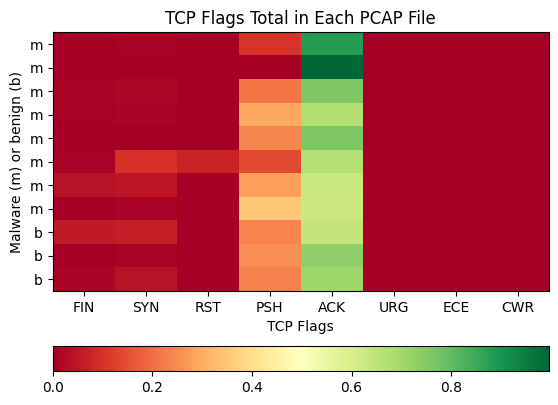

In [ ]:



flags_total = np.zeros((len(malware_files) + len(benign_files), len(FLAG_NAMES)))

for (idx, pcap) in enumerate(malware_files + benign_files):
    pf = PacketFlows(pcap, min_pkts=2, verbose=0)
    hf = pf.header_features()
    flags_total[idx] = np.sum(hf, axis=0)
    flags_total[idx] /= np.sum(flags_total[idx]) # normalize 
    
flags_total = np.array(flags_total)
fig, ax = plt.subplots()
im = ax.imshow(flags_total, cmap='RdYlGn', aspect='auto')
ax.set_yticks(np.arange(flags_total.shape[0]))
ax.set_yticklabels(['m' for _ in range(len(malware_files))] + ['b' for _ in range(len(benign_files))]);
ax.set_xticks(np.arange(len(FLAG_NAMES)))
ax.set_xticklabels(FLAG_NAMES);
ax.set_title('TCP Flags Total in Each PCAP File')
ax.set_xlabel('TCP Flags')
ax.set_ylabel('Malware (m) or benign (b)')

fig.colorbar(im, ax=ax, orientation='horizontal');


This is a function that can be used to pull out any plain text http requests like a 'GET' or 'POST' request. This didn't end up being used in the final model, but I left it in here for reference.

In [ ]:
#| export

@patch 
def count_http_raw_occurances(self: PacketFlows, 
                              filter: bytes) -> np.ndarray:
    
    def http_filter(packet, filter):
       return (TCP in packet and Raw in packet and bytes(packet[Raw]).startswith(filter))
    
    found = np.zeros(len(self.flows))
    counter = 0 
    for fid, pkts in self.flows:
        for i, pkt in enumerate(pkts):
            if http_filter(pkt, filter = filter):
                found[counter] += 1
        counter += 1
    return found



Example usage for the http request function.

In [ ]:
pf.count_http_raw_occurances(filter = b'GET') # find flows with GET requests

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In this next section we define some additional functions for computing features from the flows. These are based on the features used in the [netml]. 

In [ ]:
#| export


@patch 
def IAT_features(self: PacketFlows) -> List[np.array]:
    """Extract interarrival times (IAT) features from flows.
    Parameters
    ----------

    Returns
    -------
    features: a numpy array
        iats
    """
    
    features = []
    for fid, pkts in self.flows:
        pkt_times = [_get_frame_time(pkt) for pkt in pkts]
        iats = np.diff(pkt_times)
        features.append(iats)
    return features

@patch
def size_features(self: PacketFlows) -> List[np.array]:
    """Extract packet sizes features from flows
    Parameters
    ----------

    Returns
    -------
    features: a list
        sizes
    """

    features = []
    for fid, pkts in self.flows:
        sizes = [len(pkt) for pkt in pkts]
        features.append(sizes)

    return np.array(features)


@patch
def stats_features(flows: PacketFlows) -> np.array:
    """get basic stats features, which includes duration, pkts_rate, bytes_rate, mean,
    median, std, q1, q2, q3, min, and max.

    Returns
    -------
    features: a list
        stats
    """

    features = []
    for _, pkts in flows:
        sizes = [len(pkt) for pkt in pkts]

        sub_duration = flow_duration(pkts)
        num_pkts = len(sizes)  # number of packets in the flow
        num_bytes = sum(sizes)  # all bytes in sub_duration  sum(len(pkt))
        if sub_duration == 0:
            pkts_rate = 0.0
            bytes_rate = 0.0
        else:
            pkts_rate = num_pkts / sub_duration  
            bytes_rate = num_bytes / sub_duration

        q1, q2, q3 = np.quantile(sizes, q=[0.25, 0.5, 0.75])  # q should be [0,1] and q2 is np.median(data)
        base_features = [sub_duration, pkts_rate, bytes_rate, np.mean(sizes), np.std(sizes),
                         q1, q2, q3, np.min(sizes), np.max(sizes), num_pkts, num_bytes]

        features.append(base_features)

    return np.array(features)

@patch 
def stats_features_names(self: PacketFlows) -> List[str]:
    return ['duration', 
            'pkts_rate', 
            'bytes_rate', 
            'mean_size', 
            'std_sizes', 
            'q1_sizes', 
            'q2_sizes', 
            'q3_sizes', 
            'min_sizes', 
            'max_sizes', 
            'num_pkts', 
            'num_bytes']


## Exploratory Data Analysis

We begin by loading in the data and trying to gain some understanding of the data.

In [ ]:
def load_malware_pcap() -> pd.DataFrame:
    df = pd.DataFrame()
    for file in malware_files:
        pdf = PacketFlows.pcap2pandas(file)
        pdf['capture'] = file.name
        pdf['label'] = 1.0
        df = pd.concat([df,pdf], ignore_index=True)
    return df

def load_benign_pcap() -> pd.DataFrame:
    df = pd.DataFrame()
    for file in benign_files:
        pdf = PacketFlows.pcap2pandas(file)
        pdf['capture'] = file.name
        pdf['label'] = 0.0
        df = pd.concat([df,pdf], ignore_index=True)
    return df


In [ ]:
# Load the data into Pandas DataFrames for quick analysis.
mdata = load_malware_pcap()
bdata = load_benign_pcap()

print(f"Malware data shape: {mdata.shape}, and benign data shape: {bdata.shape}")

Decode error with {pkt.summary()}
Malware data shape: (167242, 20), and benign data shape: (61059, 20)


In [ ]:
mdata.capture.value_counts(normalize=True)

2023-03-07-Emotet-epoch4-infection-with-spambot-traffic-carved.pcap           0.451723
2023-01-16-IcedID-infection-with-Backonnect-and-VNC-and-Cobalt-Strike.pcap    0.150453
2023-03-18-Emotet-E5-infection-traffic.pcap                                   0.118959
2023-04-13-MetaStealer-C2-traffic.pcap                                        0.118702
2022-09-21-Astaroth-Guildma-infection.pcap                                    0.080901
2022-12-07-Bumblebee-infection-with-Cobalt-Strike.pcap                        0.039344
2022-01-04-Remcos-RAT-infection-traffic.pcap                                  0.033646
2023-01-05-Agent-Tesla-variant-traffic.pcap                                   0.006272
Name: capture, dtype: float64

In [ ]:
mdata.protocol.value_counts(normalize=True)

TCP     0.989466
UDP     0.009907
ICMP    0.000627
Name: protocol, dtype: float64

In [ ]:
bdata.protocol.value_counts(normalize=True)

TCP     0.570188
UDP     0.383077
ICMP    0.046735
Name: protocol, dtype: float64

In [ ]:

mdata.groupby(["capture", "protocol"]).size().reset_index(name="Counts")


,capture,protocol,Counts
0,2022-01-04-Remcos-RAT-infection-traffic.pcap,TCP,5621
1,2022-01-04-Remcos-RAT-infection-traffic.pcap,UDP,6
2,2022-09-21-Astaroth-Guildma-infection.pcap,TCP,13232
3,2022-09-21-Astaroth-Guildma-infection.pcap,UDP,243
4,2022-12-07-Bumblebee-infection-with-Cobalt-Str...,TCP,6209
5,2022-12-07-Bumblebee-infection-with-Cobalt-Str...,UDP,249
6,2023-01-05-Agent-Tesla-variant-traffic.pcap,TCP,998
7,2023-01-05-Agent-Tesla-variant-traffic.pcap,UDP,41
8,2023-01-16-IcedID-infection-with-Backonnect-an...,TCP,24970
9,2023-01-16-IcedID-infection-with-Backonnect-an...,UDP,78


In [ ]:
mdata.groupby(["capture", "port_dst"]).size().reset_index(name="Counts").sort_values(by='Counts',ascending=False).head(10)

,capture,port_dst,Counts
858,2023-03-07-Emotet-epoch4-infection-with-spambo...,465.0,16125
1949,2023-04-13-MetaStealer-C2-traffic.pcap,49825.0,12479
669,2023-01-16-IcedID-infection-with-Backonnect-an...,64823.0,8050
596,2023-01-16-IcedID-infection-with-Backonnect-an...,8080.0,7826
859,2023-03-07-Emotet-epoch4-infection-with-spambo...,587.0,7545
1947,2023-04-13-MetaStealer-C2-traffic.pcap,1775.0,7310
1117,2023-03-07-Emotet-epoch4-infection-with-spambo...,64234.0,6164
1081,2023-03-07-Emotet-epoch4-infection-with-spambo...,64164.0,6043
139,2022-09-21-Astaroth-Guildma-infection.pcap,49790.0,5885
1090,2023-03-07-Emotet-epoch4-infection-with-spambo...,64173.0,5562


In [ ]:
mdata.groupby(["capture", "port_src"]).size().reset_index(name="Counts").sort_values(by='Counts',ascending=False).head(10)

,capture,port_src,Counts
868,2023-03-07-Emotet-epoch4-infection-with-spambo...,465.0,18848
2008,2023-04-13-MetaStealer-C2-traffic.pcap,1775.0,12529
869,2023-03-07-Emotet-epoch4-infection-with-spambo...,587.0,9234
606,2023-01-16-IcedID-infection-with-Backonnect-an...,8080.0,8390
679,2023-01-16-IcedID-infection-with-Backonnect-an...,64823.0,7557
2010,2023-04-13-MetaStealer-C2-traffic.pcap,49825.0,7253
19,2022-09-21-Astaroth-Guildma-infection.pcap,80.0,6610
870,2023-03-07-Emotet-epoch4-infection-with-spambo...,7080.0,6543
871,2023-03-07-Emotet-epoch4-infection-with-spambo...,8080.0,6437
1093,2023-03-07-Emotet-epoch4-infection-with-spambo...,64164.0,5213


In [ ]:
mdata.describe()

,ip_dst_int,ip_src_int,length,mac_dst_int,mac_src_int,port_dst,port_src,label
count,1.657070e+05,1.657070e+05,167242.000000,1.672420e+05,1.672420e+05,165737.000000,165737.000000,167242.0
mean,1.637467e+09,1.809889e+09,712.858606,2.865872e+13,2.656908e+13,36881.798778,24398.298775,1.0
std,1.273197e+09,1.183365e+09,687.362543,6.278353e+13,5.474226e+13,27956.455094,27928.376870,0.0
min,9.897851e+07,0.000000e+00,42.000000,1.280447e+10,1.280447e+10,25.000000,25.000000,1.0
25%,1.685605e+08,6.237032e+08,54.000000,1.280447e+10,4.842871e+10,587.000000,465.000000,1.0
50%,1.738531e+09,1.746220e+09,207.000000,4.842871e+10,4.842871e+10,49825.000000,8080.000000,1.0
75%,2.886730e+09,2.886730e+09,1514.000000,2.683002e+13,2.683002e+13,64110.000000,51414.000000,1.0
max,4.294967e+09,3.681890e+09,1514.000000,2.814750e+14,2.134394e+14,65470.000000,65470.000000,1.0


In [ ]:
bdata.describe()

,ip_dst_int,ip_src_int,length,mac_dst_int,mac_src_int,port_dst,port_src,label
count,4.613000e+04,4.613000e+04,61059.000000,6.105900e+04,6.105900e+04,49627.000000,49627.000000,61059.0
mean,1.719452e+09,1.961301e+09,477.937536,9.258988e+13,8.469094e+13,24864.186532,21782.784633,0.0
std,1.456205e+09,1.277887e+09,587.062218,9.019149e+13,8.747990e+13,25338.449216,25432.119090,0.0
min,1.684301e+07,0.000000e+00,42.000000,0.000000e+00,0.000000e+00,13.000000,13.000000,0.0
25%,1.678383e+08,4.000452e+08,78.000000,1.101089e+12,8.796758e+12,631.000000,443.000000,0.0
50%,1.418889e+09,2.454412e+09,134.000000,6.638738e+13,6.200099e+13,7078.000000,5690.000000,0.0
75%,3.232237e+09,3.232237e+09,981.000000,1.812115e+14,1.812115e+14,55545.000000,54293.000000,0.0
max,4.294967e+09,3.640661e+09,8814.000000,2.814750e+14,2.758225e+14,65535.000000,65535.000000,0.0


## Training a model

First we define a few wrapper functions to generate the data. The first function generates a specific set of features using the flows derived from a pcap file. 

In [ ]:
#| export 

def collect_flow_stats(pcap_file: Path) -> pd.DataFrame:
    
    pf = PacketFlows(pcap_file, verbose=0)
    stats_features = pf.stats_features()
    
    tcp_ports = [20, 21, 22, 23, 25, 53, 80, 110, 143, 443, 465, 587, 993, 995, 3306, 3389, 5432, 8080]
    udp_ports = [67, 68, 123, 161, 500, 514]
    total_ports = tcp_ports + udp_ports 
    
    # Ports from the flow 
    src_ports = pd.Categorical(pf.src_ports, categories=total_ports)
    dst_ports = pd.Categorical(pf.dst_ports, categories=total_ports)
    protocol = pd.Categorical(pf.protocols, categories=['tcp', 'udp', 'icmp'])
    
    # Headers from the flow
    headers_features =  pf.header_features()
    
    X = np.hstack([stats_features,
                      headers_features,
                      ])
    
    # Put the categorical features at the end of the dataframe 
    features_names = pf.stats_features_names()
    features_names  +=  ['flags_' + str(i) for i in FLAG_NAMES] 
    df = pd.DataFrame(X, columns=features_names)
    df['src_port'] = src_ports
    df['dst_port'] = dst_ports
    df['protocol'] = protocol 
    df = pd.get_dummies(df, columns=['protocol', 'src_port', 'dst_port'], drop_first=True)
    return df
    
    



In [ ]:
df_test = collect_flow_stats(malware_files[2])

df_test.shape

(26, 68)

In [ ]:
df_test.columns

Index(['duration', 'pkts_rate', 'bytes_rate', 'mean_size', 'std_sizes',
       'q1_sizes', 'q2_sizes', 'q3_sizes', 'min_sizes', 'max_sizes',
       'num_pkts', 'num_bytes', 'flags_FIN', 'flags_SYN', 'flags_RST',
       'flags_PSH', 'flags_ACK', 'flags_URG', 'flags_ECE', 'flags_CWR',
       'protocol_udp', 'protocol_icmp', 'src_port_21', 'src_port_22',
       'src_port_23', 'src_port_25', 'src_port_53', 'src_port_80',
       'src_port_110', 'src_port_143', 'src_port_443', 'src_port_465',
       'src_port_587', 'src_port_993', 'src_port_995', 'src_port_3306',
       'src_port_3389', 'src_port_5432', 'src_port_8080', 'src_port_67',
       'src_port_68', 'src_port_123', 'src_port_161', 'src_port_500',
       'src_port_514', 'dst_port_21', 'dst_port_22', 'dst_port_23',
       'dst_port_25', 'dst_port_53', 'dst_port_80', 'dst_port_110',
       'dst_port_143', 'dst_port_443', 'dst_port_465', 'dst_port_587',
       'dst_port_993', 'dst_port_995', 'dst_port_3306', 'dst_port_3389',
       'dst_p

Aggregate the features into (X,y) and add the labels (1) for Malware and (0) for Benign.

In [ ]:
#| export 

def hash_datafiles(filelist: List[Path]) -> str:
    return hashlib.md5(("--".join(map(lambda x: str(x.name), filelist))).encode()).hexdigest()


def load_training_validation(malware_path: Path, # Path to Malware samples
                             benign_path: Path, # Path to Benign samples
                             load: bool = True, # Load the data from disk if already built
                             save: bool = True, # Save the data to disk
                             store_path: Path | None= None, # Path to store the data
                             *args , 
                             **kwargs
                             ) -> Tuple[pd.DataFrame, np.array]:
    
    benign_files = list(benign_path.glob('*.pcap*'))
    malware_files = list(malware_path.glob('*.pcap*'))
    
    benign_files.sort()
    malware_files.sort()
     
    benign_filehash = hash_datafiles(benign_files)
    malware_filehash = hash_datafiles(malware_files)
    
    X_filename = f'X_{benign_filehash}_{malware_filehash}.csv.gz'
    y_filename = f'y_{benign_filehash}_{malware_filehash}.csv.gz'
    
    # Load the data if files with those hashes exist
    store_path = malware_path.parent / "datastore" / f"{benign_filehash}_{malware_filehash}" if store_path is None else store_path
    store_path.mkdir(exist_ok=True)
    files_already_exist = (store_path / X_filename).exists() and (store_path / y_filename).exists()
    
    if load and files_already_exist:
        print(f"Data found on disk at {store_path}: Loading from there")
        X = pd.read_csv(store_path / X_filename, delimiter=',')
        y = np.loadtxt(store_path / y_filename, delimiter=',')
        return X, y
        
    Xm = pd.concat([collect_flow_stats(f) for f in malware_files])
    Xb = pd.concat([collect_flow_stats(f) for f in benign_files])
    X = pd.concat([Xm, Xb])
    y = np.array([1] * Xm.shape[0] + [0] * Xb.shape[0])

    if save:
        X.to_csv(store_path / X_filename, index=False)
        np.savetxt(store_path / y_filename, y, delimiter=',')
        
    return X, y


In [ ]:
X,y = load_training_validation(MPATH, BPATH, load=False, save=True)
print(X.shape)

(4345, 68)


In [ ]:
X.columns

Index(['duration', 'pkts_rate', 'bytes_rate', 'mean_size', 'std_sizes',
       'q1_sizes', 'q2_sizes', 'q3_sizes', 'min_sizes', 'max_sizes',
       'num_pkts', 'num_bytes', 'flags_FIN', 'flags_SYN', 'flags_RST',
       'flags_PSH', 'flags_ACK', 'flags_URG', 'flags_ECE', 'flags_CWR',
       'protocol_udp', 'protocol_icmp', 'src_port_21', 'src_port_22',
       'src_port_23', 'src_port_25', 'src_port_53', 'src_port_80',
       'src_port_110', 'src_port_143', 'src_port_443', 'src_port_465',
       'src_port_587', 'src_port_993', 'src_port_995', 'src_port_3306',
       'src_port_3389', 'src_port_5432', 'src_port_8080', 'src_port_67',
       'src_port_68', 'src_port_123', 'src_port_161', 'src_port_500',
       'src_port_514', 'dst_port_21', 'dst_port_22', 'dst_port_23',
       'dst_port_25', 'dst_port_53', 'dst_port_80', 'dst_port_110',
       'dst_port_143', 'dst_port_443', 'dst_port_465', 'dst_port_587',
       'dst_port_993', 'dst_port_995', 'dst_port_3306', 'dst_port_3389',
       'dst_p

In [ ]:
#| export 

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,  accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer 

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from dataclasses import dataclass
import seaborn as sns




In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Show the sizes of the training and test sets
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

# Show the balance of labels in the training and test sets
print("Training set has {} malware samples.".format(sum(y_train)))
print("Training set has {} legitimate samples.".format(len(y_train) - sum(y_train)))



Training set has 3041 samples.
Test set has 1304 samples.
Training set has 2060 malware samples.
Training set has 981 legitimate samples.


This tells us that the malware sample flows are twice as common as the benign samples in our dataset. This next plot attempts to do a low dimensional embedding of the features (2 dimensions) and then overlays the labels. This is just to get a sense of whether the features are separable. This plot demonstrates that the features are not linearly separable or low dimensional in nature, so we will need to use a non-linear classifier.

/Users/khannay/miniconda3/envs/malware-detect/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/khannay/miniconda3/envs/malware-detect/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


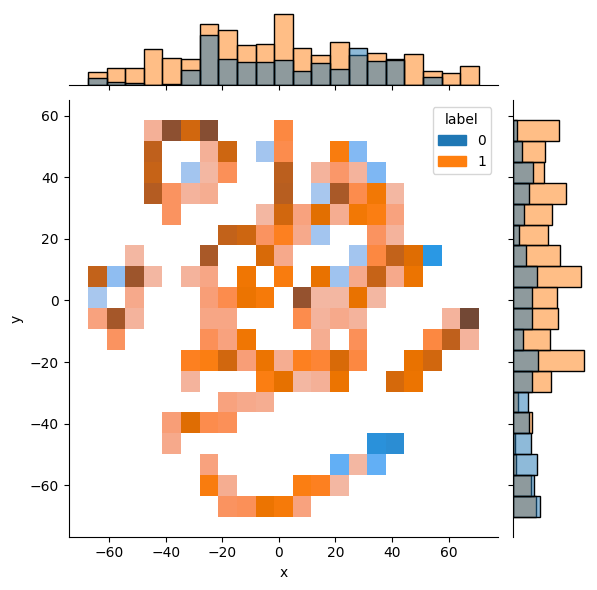

In [ ]:
# Create an tsne embedding of the data and show the labels from y_train 

TSNE_model = TSNE(n_components=2, random_state=42)
X_embedded = TSNE_model.fit_transform(X_train.to_numpy())

df_tsne = pd.DataFrame({ 'x': X_embedded[:,0], 'y': X_embedded[:,1], 'label': y_train })
sns.jointplot(data=df_tsne, x="x", y="y", hue="label", kind="hist");

## Training models

Next we will train some classifier models using these processed features. The firs step is to create some data structures for holding the results and running the training loops. 

In [ ]:
#| export 

@dataclass
class ModelCandidate():
    model: Any
    name: str

@dataclass
class ModelMetrics():
    modelcand: ModelCandidate
    accuracy_score: float
    cv_scores: np.ndarray
    auc_score: float
    f1_score: float
    confusion_matrix: np.ndarray
    
    def plot_confusion_matrix(self, 
                              ax: plt.Axes or None = None,
                              *args, 
                              **kwargs) -> None:
        if ax is None:
            ax = plt.gca()
        ConfusionMatrixDisplay(confusion_matrix=self.confusion_matrix, 
                               display_labels=['Benign', 'Malware']
                               ).plot(ax=ax, cmap = 'BuGn', *args, **kwargs)
        ax.set_title(f"Confusion Matrix: {self.modelcand.name}")
        
    def plot_roc_curve(self, 
                       X_test, 
                       y_test, 
                       ax: plt.Axes or None = None, 
                       *args, 
                       **kwargs) -> None:
        if ax is None:
            ax = plt.gca()
        RocCurveDisplay.from_estimator(self.modelcand.model, 
                                       X_test, 
                                       y_test, 
                                       ax= ax,
                                       name = self.modelcand.name,  
                                       *args, 
                                       **kwargs)
        ax.set_title(f"ROC Curves")
        
    def plot_calibration_curve(self, 
                       X_test, 
                       y_test, 
                       ax: plt.Axes or None = None, 
                       *args, 
                       **kwargs) -> None:
        if ax is None:
            ax = plt.gca()
        CalibrationDisplay.from_estimator(self.modelcand.model, 
                                          X_test, 
                                          y_test, 
                                          ax=ax, 
                                          name=self.modelcand.name,
                                          *args, 
                                          **kwargs)
        ax.set_title(f"Calibration Curves")
        
    def importances(self, top: int = 10):
        try: 
            feature_importances = self.modelcand.model['model'].feature_importances_
            indices = np.argsort(feature_importances)[::-1]
            feature_names = X_train.columns
            for f in range(min(top, X_train.shape[1])):
                print("%d. feature %s (%f)" % (f + 1, features_names[indices[f]], feature_importances[indices[f]]))
        except AttributeError:
            print("feature_importances_ not available for this model")
            

        


This function will actually train the model and compute some evaluation metrics. 

In [ ]:
#| export 


def evaluate(candidate: ModelCandidate, # Pipeline with a name attribute and a model attribute
             X_train: np.ndarray, 
             y_train: np.ndarray, 
             X_test: np.ndarray, 
             y_test: np.ndarray
             ) -> ModelMetrics:
    
    model = candidate.model
    model.fit(X_train, y_train)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    acc_score = model.score(X_train, y_train)
    auc_score = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    f1_value = f1_score(y_train, model.predict(X_train))
    confusion_matrix_val = confusion_matrix(y_test, model.predict(X_test), normalize='true')
    metrics = {'accuracy_score': acc_score, 
               'cv_scores': cv_scores, 
               'auc_score': auc_score, 
               'f1_score': f1_value, 
               'confusion_matrix': confusion_matrix_val}
    
    candidate.model = model
    return ModelMetrics(candidate, **metrics)



Here we actually build some pipelines to evaluate some model architectures. I am rescaling the numerical features and passing in the remaining categorical features as dummy coded variables. 

In [ ]:
category_features = list(range(20, X.shape[1])) # All features are categorical except the first 20 

baseline_pipe = [('scale', ColumnTransformer([('scaler', StandardScaler(), slice(0, 20))], remainder='passthrough'))]

svm_pipe = Pipeline( baseline_pipe + [('model', SVC(random_state=42, probability=True, kernel='rbf'))])
logreg_pipe = Pipeline(baseline_pipe + [('model', LogisticRegression(max_iter=10_000))])
rf_pipe = Pipeline(baseline_pipe + [('model', RandomForestClassifier(n_estimators = 30, random_state=42))])
xgb_pipe = Pipeline(baseline_pipe + [('model', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))])
knn_pipe3 = Pipeline(baseline_pipe + [('model', KNeighborsClassifier(n_neighbors=3))])
knn_pipe5 = Pipeline(baseline_pipe + [('model', KNeighborsClassifier(n_neighbors=5))])


In [ ]:

candidate_models = [ ModelCandidate(xgb_pipe, "XGBoost"),
                    ModelCandidate(rf_pipe, "Random Forest"),
                    ModelCandidate(knn_pipe3, "KNN-3"),
                    ModelCandidate(knn_pipe5, "KNN-5"),
                    ModelCandidate(svm_pipe, "SVM"),
                    ModelCandidate(logreg_pipe, "Logistic Regression"),
                    ]



Actually fit the models for evaluation.

In [ ]:
# Instantiate model 

fit_models = [evaluate(model, X_train, y_train, X_test, y_test) for model in candidate_models]


Make a confusion matrix for each model, showing the percentage of correctly classified samples.

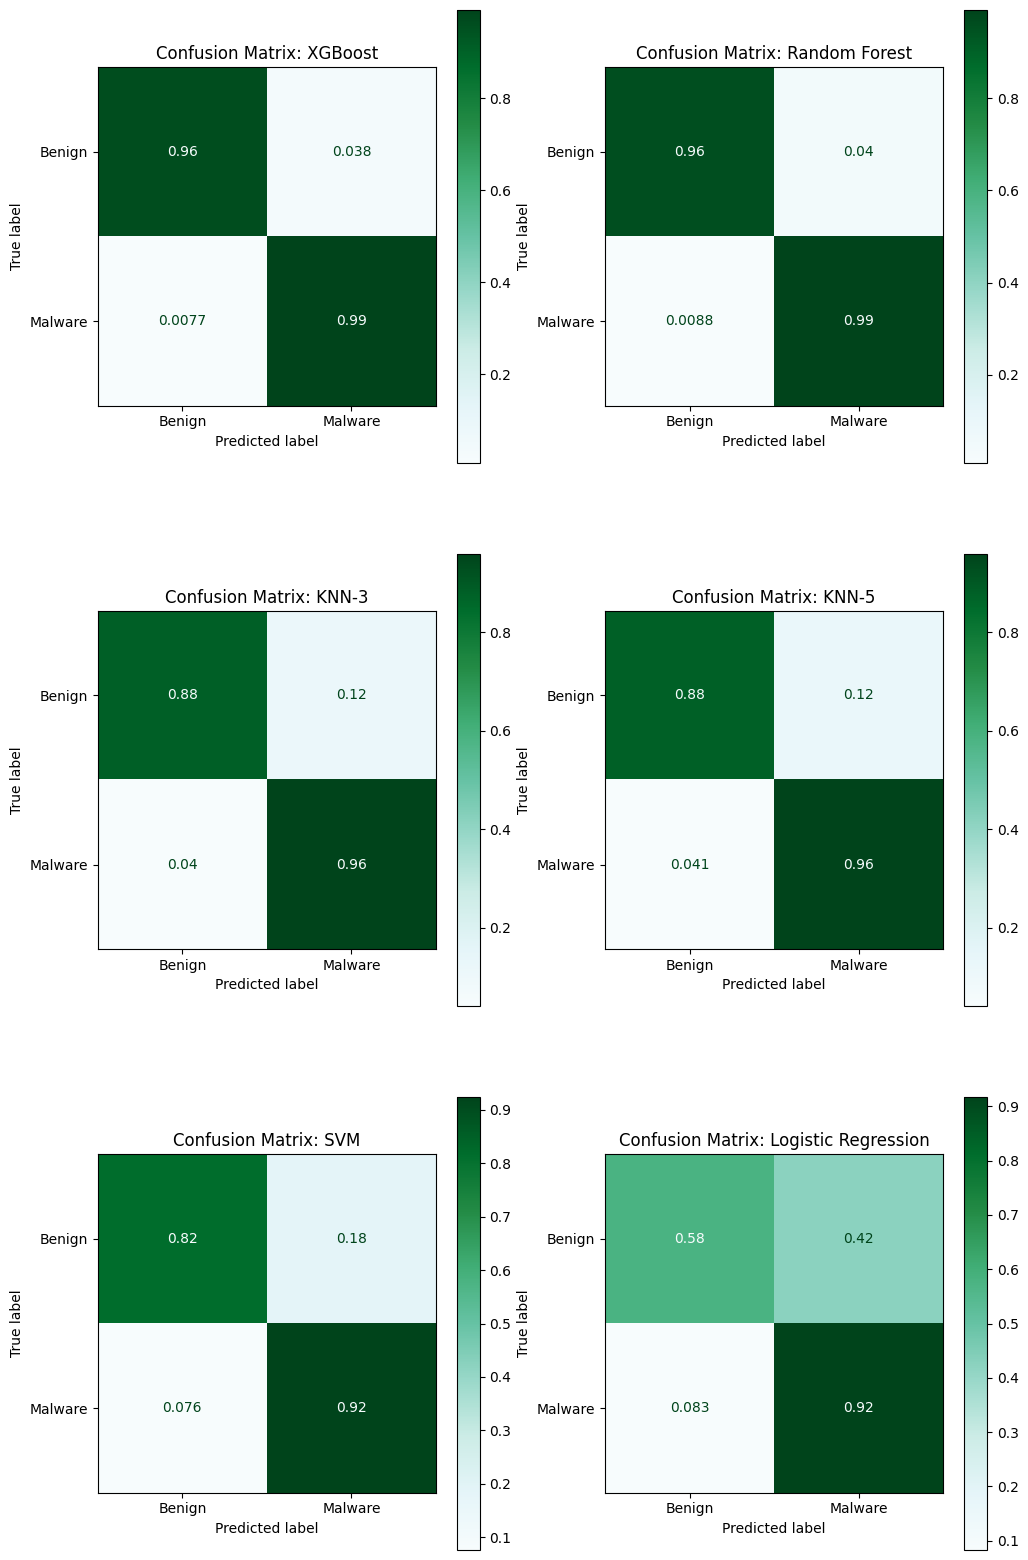

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (12,20), squeeze=False)

for idx, model in enumerate(fit_models):
    model.plot_confusion_matrix(ax=fig.axes[idx])


Next we show the ROC curves for each model. ROC curves are a way of visualizing the tradeoff between the true positive rate and the false positive rate for a classifier. The area under the curve (AUC) is a measure of the overall performance of the classifier. The higher the AUC the better the classifier. 

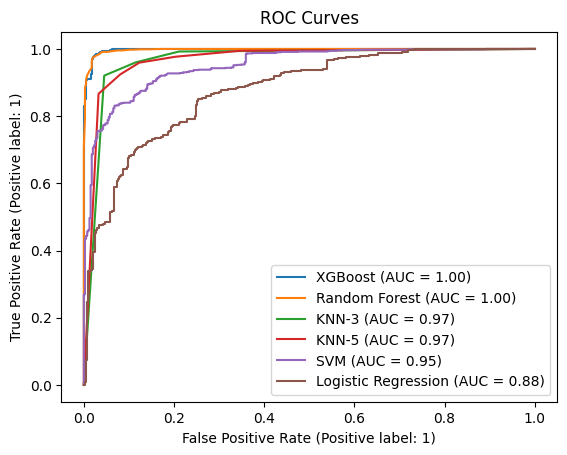

In [ ]:
for fitmodel in fit_models:
    fitmodel.plot_roc_curve(X_test, y_test, ax=plt.gca())

The calibration measures the accuracy of the probability values returned by the model. A well calibrated model will return probability values that are close to the true probability of the event. In this case each of the models are pretty well calibrated. 

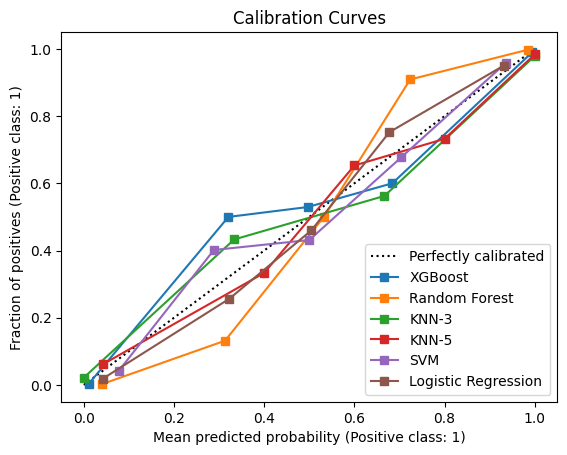

In [ ]:
for model in fit_models:
    model.plot_calibration_curve(X_test, y_test, ax=plt.gca())


Finally we can look at the cross validated accuracy scores for each model. I applied a five-fold cross validation to each model. One important component to note is the small standard deviation in the accuracy scores. This indicates that the models are not overfitting the data.

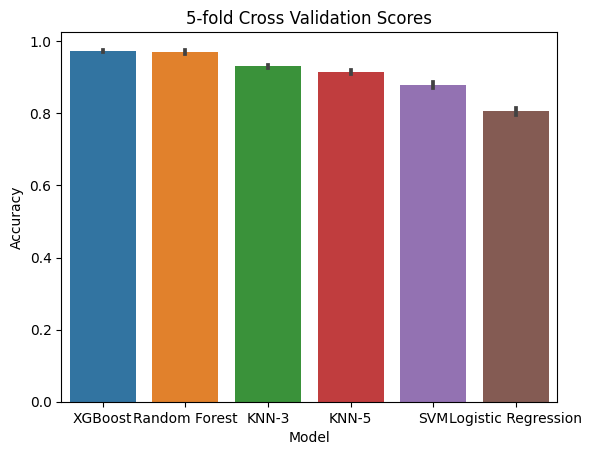

In [ ]:
# Cross validation scores

df_cv = pd.DataFrame([{'model': model.modelcand.name, 'cv_score': score} for model in fit_models for score in model.cv_scores])

ax = plt.gca()
sns.barplot(data=df_cv, x='model', y='cv_score', ax=ax)
ax.set_title("5-fold Cross Validation Scores")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model");


## Test Sets

As a final evaluation, we will test the models on a set of test data that was not used in training or validation. I downloaded a malware pcap not used in the training and some benign pcaps. The below shows the percentage of flows that were correctly classified as malware or benign.

In [ ]:
#| export 

def test_eval(malware: bool = True) -> pd.DataFrame:
    TPATH = DATA_PATH / 'test/malware' if malware else DATA_PATH / 'test/benign'
    test_type = 'malware' if malware else 'benign'
    test_files = list(TPATH.glob('**/*.pcap'))
    Xt = pd.concat([collect_flow_stats(f) for f in test_files], axis=0)
    model_names = [] 
    accuracy_scores = [] 
    for m in fit_models:
        model = m.modelcand.model
        y_true = np.ones(Xt.shape[0]) if malware else np.zeros(Xt.shape[0])
        accuracy = 1.0 - np.abs(model.predict(Xt) - y_true).sum() / Xt.shape[0]
        print(f"Model {m.modelcand.name} has accuracy {accuracy:.2f} on {test_type} test data flows")
        model_names.append(m.modelcand.name)
        accuracy_scores.append(accuracy) 
    return pd.DataFrame({'model': model_names, 'accuracy': accuracy_scores, 'test_type': [test_type] * len(model_names) })
     

In [ ]:
   
df_malware = test_eval(malware=True)
print("-----------------")
df_benign = test_eval(malware=False)
    


Model XGBoost has accuracy 0.98 on malware test data flows
Model Random Forest has accuracy 0.96 on malware test data flows
Model KNN-3 has accuracy 0.91 on malware test data flows
Model KNN-5 has accuracy 0.92 on malware test data flows
Model SVM has accuracy 0.87 on malware test data flows
Model Logistic Regression has accuracy 0.89 on malware test data flows
-----------------
Model XGBoost has accuracy 0.94 on benign test data flows
Model Random Forest has accuracy 0.94 on benign test data flows
Model KNN-3 has accuracy 0.72 on benign test data flows
Model KNN-5 has accuracy 0.68 on benign test data flows
Model SVM has accuracy 0.67 on benign test data flows
Model Logistic Regression has accuracy 0.52 on benign test data flows


Text(0.5, 1.0, 'Test Set Accuracy')

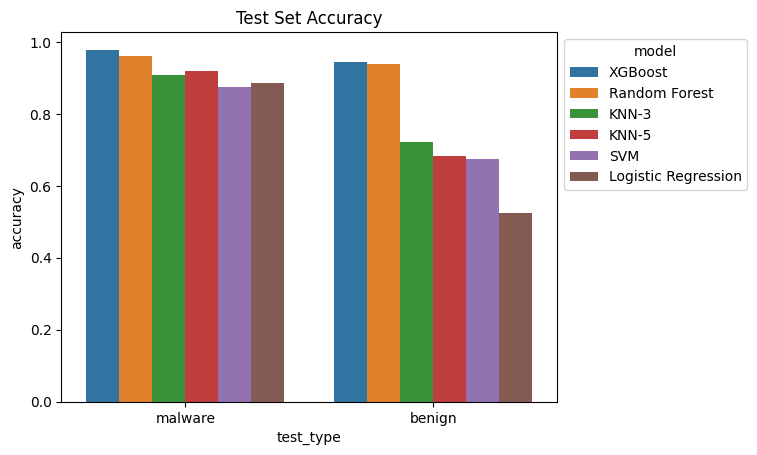

In [ ]:
df_test = pd.concat([df_malware, df_benign], axis=0)
ax=plt.gca()
sns.barplot(data=df_test, x='test_type', y='accuracy', hue='model', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Test Set Accuracy: Per Flow Classification")

In [ ]:
df_malware.head()

,model,accuracy,test_type
0,XGBoost,0.885246,malware
1,Random Forest,0.885246,malware
2,KNN-3,0.885246,malware
3,KNN-5,0.885246,malware
4,SVM,0.885246,malware


In [ ]:
#| hide

import nbdev; nbdev.nbdev_export()